In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

from skimage.morphology import label
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime
import pandas as pd

import os
from tqdm import tqdm
import json

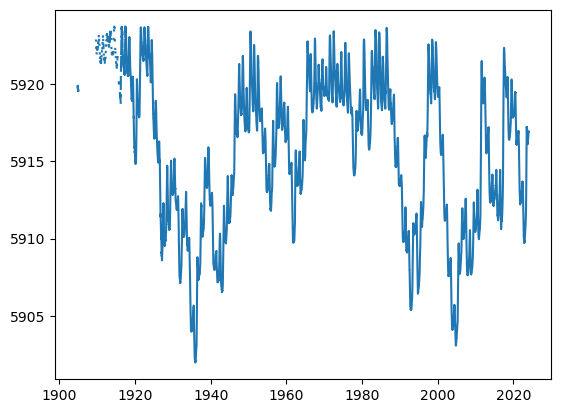

In [2]:
csv_path = "/home/ScoutJarman/Code/ILWA/data/other/usgs_data.csv"
df = pd.read_csv(csv_path, parse_dates=['datetime'])
# df = df[df['datetime'].isin(dates)]
df = df[['datetime', '309486_00062_00003']]
df = df.rename(columns={'309486_00062_00003': 'Elevation', 'datetime': 'date'})
plt.plot(df.date, df.Elevation)

Gets the watershed shape files

In [3]:
from skimage import morphology, segmentation

def label_clusters(mat):
    """Sequentially labels distinct clusters in segmentation

    The input can be either a True/False (foreground/background) segmentation,
    or a matrix where every group/cluster shares the same value.
    This will essentially relabel all the clusters starting from 0.
    If a 3D array is passed in it will label each channel separately.

    Args:
        mat (ndarray): 2D/3D array with raw segmentation (or could be labeled)

    Returns:
        ndarray: 2D/3D array with labels for each cluster
    """
    if len(mat.shape) == 3:
        results = np.zeros_like(mat)
        for c in tqdm(range(mat.shape[2])):
            results[:, :, c] = label_clusters(mat[:, :, c])
        return results
    else:
        return morphology.label(mat, connectivity=1, background=-1)


def _label_graph(mat):
    """Labels segments, similar to label_clusters.

    Like label_clusters, this labels each cluster in a segmentation starting from 0.
    This uses a graph, and labels based on connected components.
    It also returns the counts for each component for use to remove small groups.

    Args:
        mat (ndarray): a 2d matrix to label clusters

    Returns:
        tuple: the segmentation map, and the counts for each segment
    """
    seg = label_clusters(mat)
    counts = np.bincount(seg.flatten())
    return seg, counts

def _remove_singletons(seg, min_size, relabel=True):
    """Given a segmentaiton, it removes merges small clusters.

    Any segment smaller than min_size will get merged with the neighbor with the most touching edges.

    Args:
        seg (ndarray): 2d array of labeled segments.

    Returns:
        ndarray: relabeled segmentation with small clusters merged with nearby clusters.
    """
    if relabel:
        seg, counts = _label_graph(seg)
        for i in range(len(counts)):
            if counts[i] < min_size:
                temp = seg == i
                neigh = seg[segmentation.find_boundaries(temp, 2, 'outer')]
                new_lab = np.bincount(neigh).argmax()
                seg[seg == i] = new_lab
        return label_clusters(seg)
    else:
        for i in np.unique(seg):
            temp = seg == i
            if np.sum(temp) < min_size:
                neigh = seg[segmentation.find_boundaries(temp, 2, 'outer')]
                new_lab = np.bincount(neigh).argmax()
                seg[seg == i] = new_lab
        new_lab = 1
        new_seg = seg.copy()
        for i in np.unique(seg):
            new_seg[seg == i] = new_lab
            new_lab += 1
        return new_seg


In [4]:
# read in watersheds
shapefile_path = "/home/ScoutJarman/Code/ILWA/data/shapefiles/id_ut8_1601_exp/id_ut8_1601_exp.shp"
watersheds = gpd.read_file(shapefile_path)
watersheds

,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,referenceg,areaacres,areasqkm,states,huc8,name,geometry
0,{E909EC67-8CE3-4B76-9837-37A1213809E2},None,None,None,None,2020-11-30,None,1285620.74,5202.73,"UT,WY",16010101,Upper Bear,"POLYGON ((-110.79684 42.05824, -110.79681 42.0..."
1,{F08762FD-10B0-4D76-B388-EA773C06C23A},None,None,None,None,2020-06-04,None,1118676.10,4527.13,UT,16020310,Great Salt Lake,"POLYGON ((-112.83985 41.69923, -112.83973 41.6..."
2,{505FFE08-4104-4140-AC9C-D1CDF623BE15},None,None,None,None,2019-11-15,None,821269.05,3323.56,"ID,UT",16010202,Middle Bear,"POLYGON ((-111.70071 42.65360, -111.70033 42.6..."
3,{FC83B338-3ED6-4445-9562-C00881CE00F1},None,None,None,None,2020-06-04,None,1756043.78,7106.46,"UT,WY",14040107,Blacks Fork,"POLYGON ((-110.64519 42.35874, -110.64593 42.3..."
4,{962BF639-7A2F-4EE8-ACEF-324806B5F9BD},None,None,None,None,2012-06-11,None,773077.34,3128.54,UT,16020304,Rush-Tooele Valleys,"POLYGON ((-112.50254 40.91502, -112.50280 40.9..."
5,{56AC25AE-737F-4476-A9ED-DD6E9201E123},None,None,None,None,2021-01-13,None,845496.40,3421.61,UT,16020102,Lower Weber,"POLYGON ((-111.94079 41.42067, -111.94057 41.4..."
6,{9A190882-951A-4D46-9BB3-BDBC031ADB45},None,None,None,None,2012-06-11,None,1447003.99,5855.82,"ID,UT",16020309,Curlew Valley,"POLYGON ((-112.66222 42.47055, -112.66219 42.4..."
7,{14E223D4-E9B7-412D-88EF-6242F38DCB2F},None,None,None,None,2021-01-13,None,520885.32,2107.95,UT,16020204,Jordan,"POLYGON ((-111.97172 40.93539, -111.97180 40.9..."
8,{16AABFAC-B6C0-4665-99C9-8EC0C3B03D3F},None,None,None,None,2021-01-13,None,746377.12,3020.48,"UT,WY",16020101,Upper Weber,"POLYGON ((-111.38276 41.37360, -111.38229 41.3..."
9,{08DCF3AF-261F-46A9-9628-0F17C5823D2A},None,None,None,None,2020-06-04,None,810819.31,3281.27,"ID,UT",16010201,Bear Lake,"POLYGON ((-111.64622 42.85186, -111.64584 42.8..."


In [5]:
# get raster meta data information
raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif"
with rasterio.open(raster_path) as handle:
    raster_arr = handle.read(1)
    meta = handle.meta

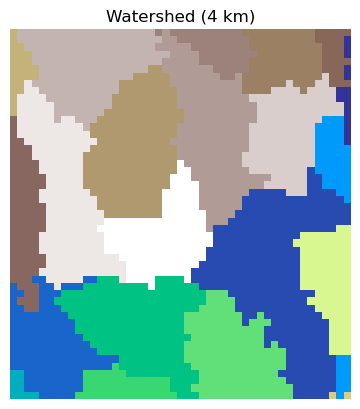

In [7]:
# Make segmentations
seg = np.zeros_like(raster_arr)
for idx, geometry in enumerate(watersheds['geometry']):
    mask = geometry_mask([geometry], out_shape=raster_arr.shape, transform=meta['transform'], invert=True)
    seg[mask] = idx + 1
# seg

fig, axs = plt.subplots(1)
axs.imshow(seg, cmap='terrain')
axs.set_axis_off()
axs.set_title("Watershed (4 km)")
plt.savefig("Watershed4km.jpg")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

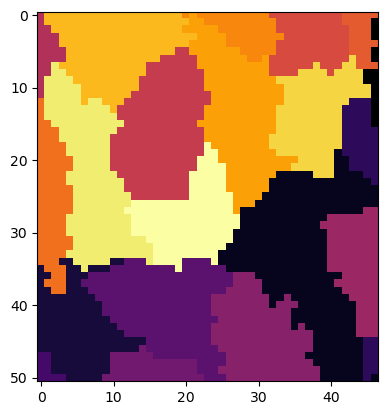

In [8]:
new_seg = seg.astype(int)
new_seg = _remove_singletons(new_seg, 3, False)

plt.imshow(new_seg, cmap='inferno')
np.unique(new_seg)

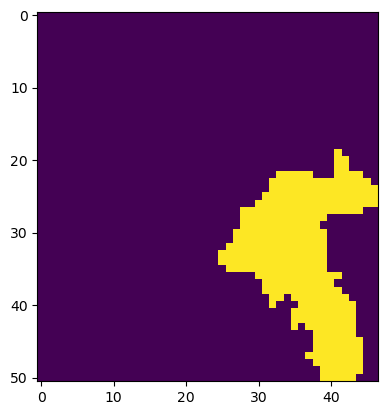

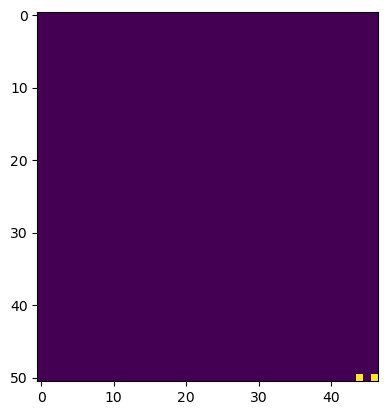

In [9]:
plt.imshow(seg == 1)
plt.show()
plt.imshow(seg == 15)

In [10]:
for i in np.unique(new_seg):
    print(f"seg {i} -> {np.unique(seg[new_seg == i])}")

seg 1 -> [0.]
seg 2 -> [ 1. 15.]
seg 3 -> [2.]
seg 4 -> [4.]
seg 5 -> [5.]
seg 6 -> [6.]
seg 7 -> [8.]
seg 8 -> [9.]
seg 9 -> [12.]
seg 10 -> [16.]
seg 11 -> [17.]
seg 12 -> [18.]
seg 13 -> [19.]
seg 14 -> [20.]
seg 15 -> [21.]
seg 16 -> [22.]
seg 17 -> [23.]
seg 18 -> [24.]
seg 19 -> [25.]
seg 20 -> [26.]


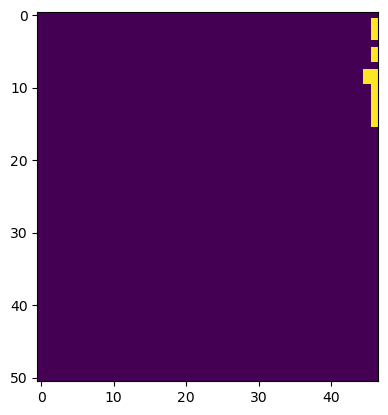

In [11]:
plt.imshow(seg == 0)


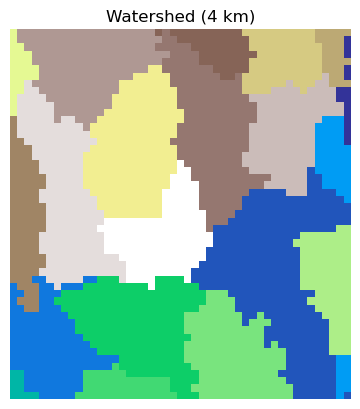

In [13]:
# read in watersheds
shapefile_path = "/home/ScoutJarman/Code/ILWA/data/shapefiles/id_ut8_1601_exp/id_ut8_1601_exp.shp"
watersheds = gpd.read_file(shapefile_path)

# get raster meta data information
raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif"
with rasterio.open(raster_path) as handle:
    raster_arr = handle.read(1)
    meta = handle.meta

# Make segmentations
seg = np.zeros_like(raster_arr)
for idx, geometry in enumerate(watersheds['geometry']):
    mask = geometry_mask([geometry], out_shape=raster_arr.shape, transform=meta['transform'], invert=True)
    seg[mask] = idx + 1

seg = seg.astype(int)
seg = _remove_singletons(seg, 3, False)


fig, axs = plt.subplots(1)
axs.imshow(seg, cmap='terrain')
axs.set_axis_off()
axs.set_title("Watershed (4 km)")
plt.savefig("Watershed4km.jpg")

Loop through each ppt file, and aggregate it according to the watersheds

In [14]:
folders_in = ["/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/tmin_81_23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/tmax_81_23",
              "/home/ScoutJarman/Code/ILWA/data/rasters/UA/swe_81-23"]
var_names = ['ppt', 'tmin', 'tmax', 'swe']
input_path = "/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif"

with open("/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif.aux.json", 'r') as json_file:
    layer_names = json.load(json_file)['time']
parsed_dates = np.asarray([datetime.strptime(date_str, "%Y-%m-%d") for date_str in layer_names])


In [15]:
data = []
dates = []
pbar =  tqdm(os.listdir(folders_in[0]))
for file in pbar:
    year = int(file[3:7])
    month = int(file[7:9])
    day = int(file[9:11])
    nums = file[3:-4]
    dtime = datetime(year, month, day)

    try:
        tmp_data = []
        for i, f_in in enumerate(folders_in):
            with rasterio.open(os.path.join(f_in, f"{var_names[i]}{nums}.tif")) as handle:
                raster_arr = handle.read(1)
            for l in np.unique(seg):
                m = np.mean(raster_arr[seg == l])
                tmp_data.append(m)
        data.append(tmp_data)
        dates.append(dtime)
    except:
        pbar.set_description(f"Don't have all variables for {dtime}")
data = np.asarray(data)

Don't have all variables for 2022-11-29 00:00:00:   2%|▏         | 276/15521 [00:21<18:47, 13.52it/s]

In [ ]:
inds = np.argsort(dates)
data_s = data[inds]

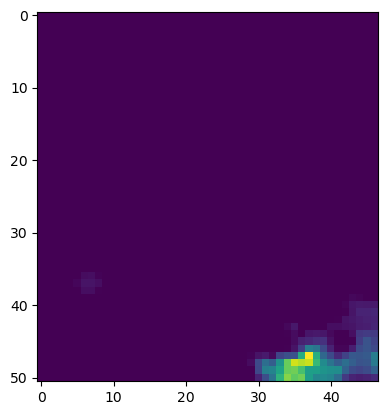

In [2]:
with rasterio.open("/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif") as handle:
    raster_arr = handle.read(1)

plt.imshow(raster_arr)

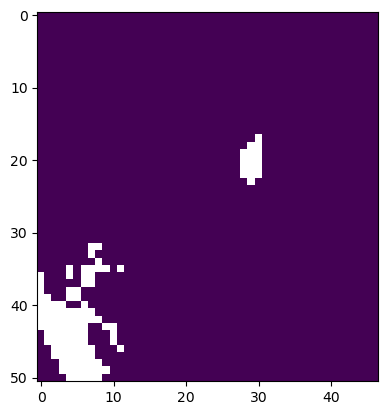

In [5]:
with rasterio.open("/home/ScoutJarman/Code/ILWA/data/rasters/UA/ua_swe_daily_bearlake.tif") as handle:
    raster_arr = handle.read(1)

plt.imshow(raster_arr)

In [8]:
np.isnan(raster_arr).sum()  

116

In [12]:
raster_arr.shape, raster_arr.shape[0] * raster_arr.shape[1], (116 / 2397) * 100

((51, 47), 2397, 4.839382561535253)

# Load in response variables

In [ ]:
csv_path = "/home/ScoutJarman/Code/ILWA/data/other/usgs_data.csv"
df = pd.read_csv(csv_path, parse_dates=['datetime'])
df = df[df['datetime'].isin(dates)]
df = df[['datetime', '309486_00062_00003']]
df = df.rename(columns={'309486_00062_00003': 'Elevation', 'datetime': 'date'})

# column_names = [f"ppt_{i}" for i in np.unique(seg)] + [f"tmean_{i}" for i in np.unique(seg)]
column_names = []
for v_nam in var_names:
    column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
data_df = pd.DataFrame(data_s, columns=column_names)
df.index = data_df.index

df_daily = pd.concat([df, data_df], axis=1)

df_daily.to_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", index=False)

In [ ]:
plt.plot(df_daily['date'], df_daily['Elevation'])

In [ ]:
print(df_daily.columns)

In [ ]:
plt.plot(df_daily['swe_1'][:2*365])

# LOCA Formatting

In [ ]:
# get raster meta data information
def format_data(max_hist=datetime(2021, 9, 30), min_date=datetime(1981, 10, 1)):
    raster_path = "/home/ScoutJarman/Code/ILWA/data/rasters/PRISM/ppt_81-23/ppt19810101.tif"
    with rasterio.open(raster_path) as ref_handle:
        for r in ["r1", "r2", "r3"]:
            folders_in = [f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/ppt_{r}",
                        f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/tmin_{r}",
                        f"/home/ScoutJarman/Code/ILWA/data/rasters/LOCA/tmax_{r}"]
            var_names = ['ppt', 'tmin', 'tmax']
            # Load in variables
            data = []
            dates = []
            pbar =  tqdm(os.listdir(folders_in[0]))
            for file in pbar:
                year = int(file[3:7])
                month = int(file[7:9])
                day = int(file[9:11])
                nums = file[3:-4]
                dtime = datetime(year, month, day)

                raster_arr = np.zeros_like(ref_handle.read(1))
                try:
                    tmp_data = []
                    for i, f_in in enumerate(folders_in):
                        with rasterio.open(os.path.join(f_in, f"{var_names[i]}{nums}.tif")) as handle:
                            transform_larger, _, __ = calculate_default_transform(
                                    handle.crs, ref_handle.crs, handle.width, handle.height,
                                    *handle.bounds, resolution=ref_handle.res)
                            # Perform resampling
                            reproject(
                                source=handle.read(1),
                                destination=raster_arr,
                                src_transform=handle.transform,
                                src_crs=handle.crs,
                                dst_transform=transform_larger,
                                dst_crs=ref_handle.crs,
                                resampling=Resampling.bilinear)

                        for l in np.unique(seg):
                            m = np.mean(raster_arr[seg == l])
                            tmp_data.append(m)
                    data.append(tmp_data)
                    dates.append(dtime)
                except:
                    pbar.set_description(f"Don't have all variables for {dtime}")

            # Sorts the data by date
            data = np.asarray(data)
            dates = np.asarray(dates)
            # Sort data
            inds = np.argsort(dates)
            data_s = data[inds]
            dates = dates[inds]

            # Make the historical dataframe
            column_names = []
            for v_nam in var_names:
                column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
            hist_df = pd.DataFrame(data_s, columns=column_names)
            hist_dates = pd.DataFrame({'date': dates})
            hist_df = pd.concat([hist_dates, hist_df], axis=1)
            hist_df.to_csv(f"/home/ScoutJarman/Code/ILWA/data/other/Daily_{r}.csv", index=False)
            
            # # Make the future dataframe
            # column_names = []
            # for v_nam in var_names:
            #     column_names += [f"{v_nam}_{i}" for i in np.unique(seg)]
            # futu_df = pd.DataFrame(data_s[np.invert(inds)], columns=column_names)
            # futu_dates = pd.DataFrame({'date': dates[np.invert(inds)]})
            # futu_df = pd.concat([futu_dates, futu_df], axis=1)
            # futu_df.to_csv(f"/home/ScoutJarman/Code/ILWA/data/other/Daily_futu{r}.csv", index=False)

In [ ]:
data, dates = format_data()

## Fixing units for LOCA

In [12]:
ds = 'ssp585_r3'
df = pd.read_csv(f"data/other/Daily_{ds}.csv")
def k_to_c(k):
    return k - 273.15

def tmin_shift(k):
    return k + 2.14

df.loc[:, df.columns.str.startswith('tmax_')] = df.filter(like='tmax_').apply(k_to_c)
df.loc[:, df.columns.str.startswith('tmin_')] = df.filter(like='tmin_').apply(k_to_c)
df.loc[:, df.columns.str.startswith('tmin_')] = df.filter(like='tmin_').apply(tmin_shift)

def ppt_to_in(k):
    return k * 86400

df.loc[:, df.columns.str.startswith('ppt_')] = df.filter(like='ppt_').apply(ppt_to_in)
df.to_csv(f"data/other/Daily_{ds}_conv2.csv", index=False)

In [ ]:
plt.hist(df.tmin_1)

In [ ]:
df = pd.read_csv("data/other/Daily_rcp45.csv")
plt.hist(df.tmin_1)

In [ ]:
df = pd.read_csv("data/other/Daily.csv")
plt.hist(df.tmin_1)